In [24]:
import numpy as np
import math
import cmath
import warnings
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io.wavfile import write
from scipy.io.wavfile import read
from scipy import signal

In [61]:
#Provided Code
class dft():
    def __init__(self, x, fs, K=None):
    # START: SANITY CHECK OF INPUTS.
        if (type(fs) != int) or (fs<=0):
            raise NameError('The frequency fs should be a positive integer.')
        if not isinstance(x, np. ndarray):
            raise NameError('The input signal x must be a numpy array.')
        if isinstance(x, np. ndarray):
            if x.ndim!=1:
                raise NameError('The input signal x must be a numpy vector array.')
        self.x=x
        self.fs=fs
        self.N=len(x)
        if K == None:
            K = len(self.x)
        # START: SANITY CHECK OF INPUTS.
        if (type(K) != int) or (K <= 0) or (K < 0):
            raise NameError('K should be a positive integer.')
        self.K=K
        self.f=np.arange(self.K)*self.fs/self.K # (0:K-1) just creates a vector from 0 to K by steps of 1.
        self.f_c=np.arange(-np.ceil(K/2)+1,np.floor(self.K/2)+1)*self.fs/self.K
    def changeK(self,K):
        """
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the DFT. This function changes the attribute K of the class.
        """
        if (type(K) != int) or (K <= 0) or (K <  0):
            raise NameError('K should be a positive integer.')
        old_K=self.K
        self.K=K
        self.f=np.arange(self.K)*self.fs/self.K # (0:K-1) just creates a vector from 0 to K by steps of 1.
        self.f_c=np.arange(-np.ceil(K/2)+1,np.floor(self.K/2)+1)*self.fs/self.K
        # This accounts for the frequencies
        # centered at zero. I want to be guaranteed that k=0 is always a
        # possible k. Then, I also have to account for both even and odd choices
        # of K, and that's why the floor() function appears to round down the
        # numbers.
        print('The value of K was succefully change from %d to %d'%(old_K,self.K))
        pass
    
    def solve3(self):
        X=np.fft.fft(self.x,self.K)/np.sqrt(self.N);
        # \\\\\ CENTER FFT.
        X_c=np.roll(X,int(np.ceil(self.K/2-1))) # Circularly shift X to get it centered in f_c==0
        return [self.f,X,self.f_c,X_c]

class idft():
    """
    idft Inverse Discrete Fourier transform.
    """

    def __init__(self, X, fs, N, K=None):
        """
        :param X: Input DFT X
        :param fs: Input integer fs contains the sample frequency
        :param N: The number of total signal samples N
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the iDFT.
        """
        self.X = X
        self.fs = fs
        self.N = N
        self.K = K
        if self.K == None:
            self.K = int(len(X) / 2) - 1

    def solve_K(self):
        """
        \\\\\ METHOD: Compute the iDFT with truncated K coefficients (Due to computation complexity, we will not use it in Section 2)
        :return iDFT x of duration N from partial DFT X, i.e., X[0], ..., X[K] with K < N/2
        :Treal the realt time vector of size N
        """
        x = np.zeros(self.N)

        for n in range(self.N):
            x[n] = 1 / np.sqrt(self.N) * self.X[0] * np.exp(1j * 2 * cmath.pi * 0 * n / self.N)
            for k in range(1, self.K + 1):
                x[n] = x[n] + 1 / np.sqrt(self.N) * self.X[k] * np.exp(1j * 2 * cmath.pi * k * n / self.N)
                x[n] = x[n] + 1 / np.sqrt(self.N) * np.conj(self.X[k]) * np.exp(-1j * 2 * cmath.pi * k * n / self.N)

        Ts = 1 / self.fs
        Treal = np.arange(self.N) * Ts

        return x, Treal

    def solve_ifft(self):
        """
        \\\\\ METHOD: Compute the iDFT with provided function np.fft.ifft (Computationally efficient)
        :Treal the realt time vector of size N
        """
        x = np.fft.ifft(self.X, self.N) * np.sqrt(self.N)

        Ts = 1 / self.fs
        Treal = np.arange(self.N) * Ts

        return x, Treal
class recordsound():
    """
    recordsound Record your voice for T time sampled at a frequency fs
    solve() generates a sampled signal of your voice and save it into a wav file
    """
    def __init__(self, T, fs):
        """
        :param T: the duration time
        :param fs: the sampling frequency
        """
        self.T = T
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the triangular pulse vector x
        :N: The sample duration
        """
        print('start recording')
        voicerecording = sd.rec(int(self.T * self.fs), self.fs, 1)
        sd.wait()  # Wait until recording is finished
        print('end recording')
        write('myvoice.wav', self.fs, voicerecording)  # Save as WAV file 
        
        return voicerecording

In [18]:

def q_12(mu, sigma_list, T, fs):    
    for sigma in sigma_list:
        # Generate Gaussian signals
        gau_pulse = gaussian_pulse(mu, sigma, T, fs)
        
        # Calculate the dft
        gaupulse_dft = dft(gau_pulse.sig, fs)
        [freqs, X, f_c, X_c] = gaupulse_dft.solve3()

        # Calculate the ft and scale with fs/sqrt(N)
        gau_ft_sig = gau_ft(mu, sigma, f_c) * fs/ np.sqrt( int(np.floor(T * fs))*2 )

        # Plot
        fig, axs = plt.subplots(3)
        axs[0].grid()
        axs[1].grid()
        axs[2].grid()
        fig.suptitle('Gaussian Pulse of Sigma %3.2fs ' % (sigma))
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
        axs[0].plot(gau_pulse.t, gau_pulse.sig)
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Signal')
        axs[1].plot(f_c, abs(X_c))
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('DFT')
        axs[2].plot(f_c, gau_ft_sig)
        axs[2].set_xlabel('Frequency (Hz)')
        axs[2].set_ylabel('FT')
        plt.show()

C:\Users\Mosta\AppData\Local\Temp/ipykernel_1828/3477190449.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.N = np.int(np.floor(T * fs))
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


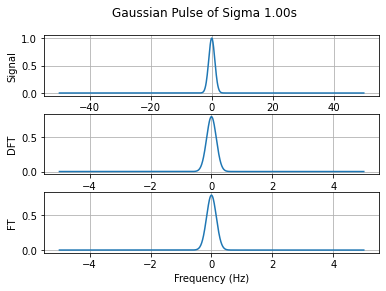

C:\Users\Mosta\AppData\Local\Temp/ipykernel_1828/3477190449.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.N = np.int(np.floor(T * fs))
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


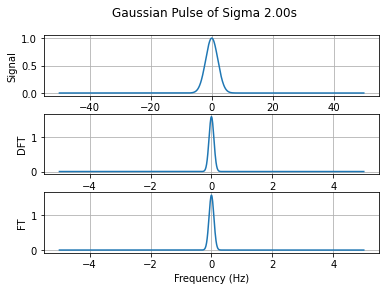

C:\Users\Mosta\AppData\Local\Temp/ipykernel_1828/3477190449.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.N = np.int(np.floor(T * fs))
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


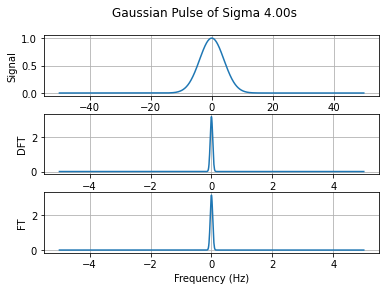

In [19]:
sigmalist = [1, 2, 4]
duration_of_signal = 50
sampling_frequency = 10
q_12(0, sigmalist, duration_of_signal, sampling_frequency)

In [35]:
def bandlimit(x, fs, fmax):
    N = len(x) 
    DFT = dft(x, fs)
    [freqs, X, f_c, X_c] = DFT.solve3()
    index_min = np.min( np.where(f_c >= -fmax)[0])
    index_max = np.max( np.where(f_c <= fmax)[0])
    X_band = np.concatenate(( np.zeros(index_min+1), X_c[index_min: index_max] ,  np.zeros( N - index_max-1)))
    X_band_n = np.roll( X_band, int(np.ceil( N / 2 )))
      
    iDFT = idft(X_band_n, fs, N)
    x_bandlim, Treal = iDFT.solve_ifft()
    
    return x_bandlim.real, Treal,  X_c, f_c, X_band

        
def q_21(x, x_bl, Treal, X_c, f_c, X_band):
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('original signal and spectrum' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, X_c)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('DFT')

    plt.show() 
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('bandlimited spectrum and signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    axs[1].plot(Treal, x_bl)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    axs[0].plot(f_c, X_band)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('DFT')
    plt.show() 
    
    write('bandlimited_myvoice.wav', fs, x_bl.astype(np.float32))

start recording
end recording
start recording
end recording
120000


C:\Users\Mosta\AppData\Local\Temp/ipykernel_1828/1511066806.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_band_n = np.roll( X_band, np.int(np.ceil( N / 2 )))
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


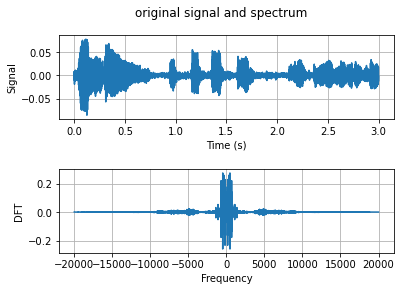

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


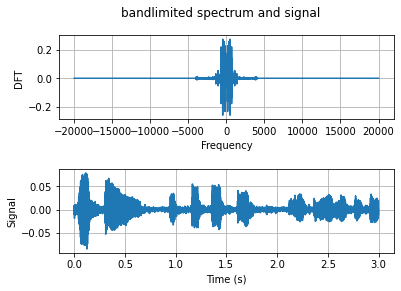

In [30]:
#Problem 2.1
myvoice = recordsound(3, 40000)      
x1 = myvoice.solve().reshape(3 * 40000)

myvoice = recordsound(3, 40000)      
x2 = myvoice.solve().reshape(3 * 40000)

fs, x = read("myvoice.wav")
fmax = 4000
N = len(x)
print(N)
x_band, Treal, X_c, f_c, X_band = bandlimit(x, fs, fmax)
q_21(x, x_band, Treal, X_c, f_c, X_band)

We observe here that our original signal in the frequency domain has almost no energy past f = 4000Hz and -4000Hz. Because of this, when we truncate the signal, we are removing a minimal amount of energy, and thus retaining approximately the same amount of energy. This result follows from Parseval's theorem, and it is the reason why our signal and bandilimited signal look almost identical in the frequency domain, but when we go back to the time domain, we see that our second signal has considerably less noise than the first. When we play back the bandlimited signal, we observe that it sounds the same, though, due to the low amount of energy lost from truncation.

In [36]:
def q_22(x, g, fs):

    N = len(x)
    n = np.arange(N)
    discrete_exponential = np.exp(2 * math.pi*j* g * n / fs)
    x_mod = x * discrete_exponential
    
    return x_mod
    



In [56]:
def q_23(x_band, x_mod, fs, Treal):
    
    DFT = dft(x_band, fs)
    [freqs, X, f_c, X_c] = DFT.solve3()
    
    DFT_mod = dft(x_mod, fs)
    [freqs, X, f_mod, X_mod] = DFT_mod.solve3()
    
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Modulated Signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    axs[0].plot(Treal, x_band)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, x_mod)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 
    
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Modulated Signal Spectrum' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    axs[0].plot(f_c, X_c)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('DFT')
    axs[1].plot(f_mod, X_mod)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('DFT')
    plt.show()

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


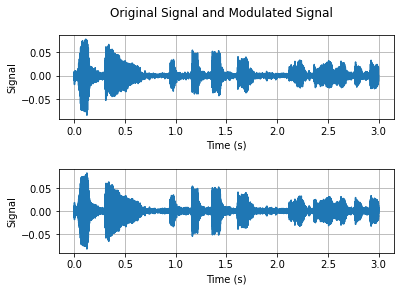

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


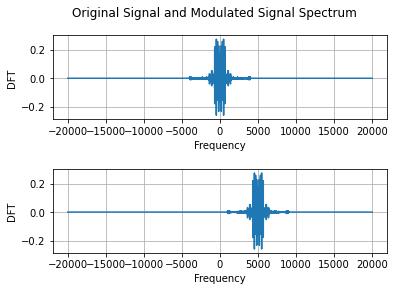

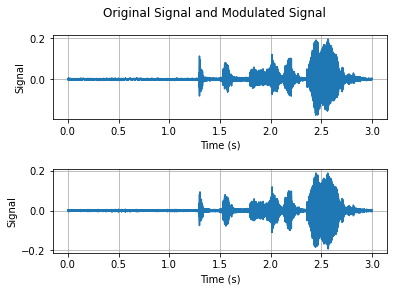

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


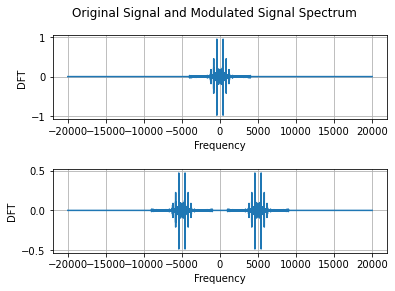

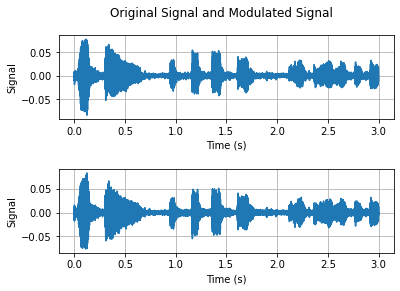

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


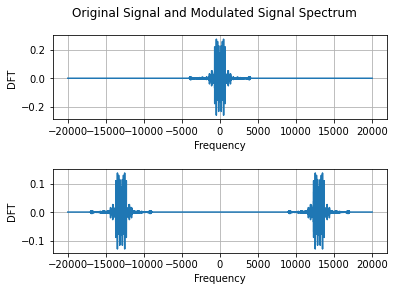

In [63]:
#Problems 2.2 and 2.4
def cos_modu(x, g, fs):  
    N = len(x)
    n = np.arange(N)
    discrete_cosine = np.cos(2 * math.pi * g * n / fs)
    x_mod = x * discrete_cosine
    return x_mod
g1 = 5000
g2 = 13000
x_mod = cos_modu(x_band, g1, fs)
x_mod = q_22(x_band, g1, fs)
x_band1, Treal, X_c, f_c, X_band = bandlimit(x1, fs, fmax)
q_23(x_band, x_mod, fs, Treal)
myvoice1 = recordsound(3, 40000)
fs, x1 = read("myvoice1.wav")
x_mod1 = cos_modu(x_band1, g1, fs)
q_23(x_band1, x_mod1, fs, Treal)

fs, x2 = read("myvoice.wav")
x_band2, Treal,X_c, f_c, X_band = bandlimit(x2, fs, fmax)
x_mod2 = cos_modu(x_band2, g2, fs)
q_23(x_band2, x_mod2, fs, Treal)

z = x_mod1 + x_mod2



Here we are simply modulating our signal and centering it about first g = 5000Hz and then g = 13000Hz. The first time we modulate it directly by manipulating our complex exponentials, and the second time we convert our complex exponentials to cosines (we omit the sine since it's imaginary and only care for the real part), and we manipulate the cosine by multiplying the inside function by 13000. We can observe that these both simply modulate our signals, except one is centered about 5000Hz and the other about 13000Hz in the frequency domain. We then add our two modulated signals together to get our z, which we plot in the next problem.

These two problems are essentially doing the same thing, but with different values of g and one using a cosine signal, so they are combined into one problem in the solution, so I just left it

In [66]:

def q_25(z, g, fs, fmax):

    N= len(z)
    DFT = dft(z, fs)
    [freqs, X, f_Zc, Z_c] = DFT.solve3()
    y_demod_inter = cos_modu(z, g, fs)
    DFT = dft(y_demod_inter, fs)
    [freqs, Y, f_c, Y_demod_inter] = DFT.solve3()
    
    index_min = np.min( np.where(f_c >= -fmax)[0])
    index_max = np.max( np.where(f_c <= fmax)[0])
    Y_demod = np.concatenate(( np.zeros(index_min+1), Y_demod_inter[index_min: index_max]*2 ,  np.zeros( N - index_max-1)))
    Y_demod_n = np.roll( Y_demod, int(np.ceil( N / 2 )) )
    iDFT = idft(Y_demod_n, fs, N)
    y_demod, Treal = iDFT.solve_ifft()
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Demodulated Signal Spectrum' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    axs[0].plot(f_c, Y_demod_inter)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('DFT')
    axs[1].plot(f_c, Y_demod)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('DFT')
    plt.show() 
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Modulated Signal Spectrum' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    axs[0].plot(f_Zc, Z_c)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('DFT')
    axs[1].plot(f_c, Y_demod)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('DFT')
    plt.show() 
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Mixed Signal and Demodulated Signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    axs[0].plot(Treal, z)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, y_demod.real)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 
    
    write('demodulated_myvoice'+str(g)+'.wav', fs, y_demod.real.astype(np.float32))
    
    return y_demod.real

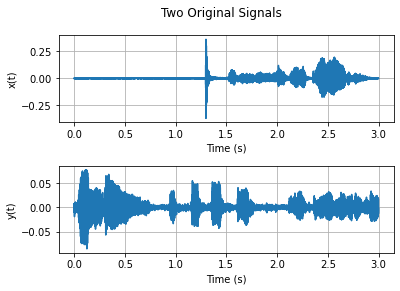

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


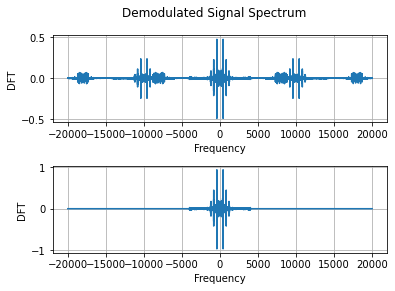

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


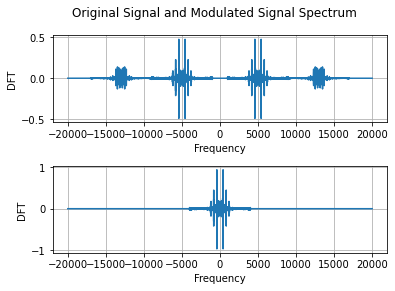

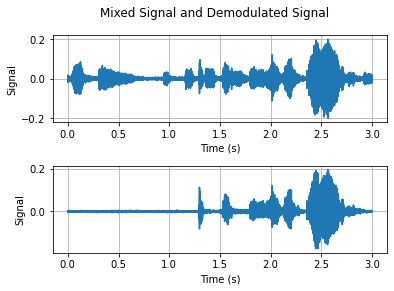

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


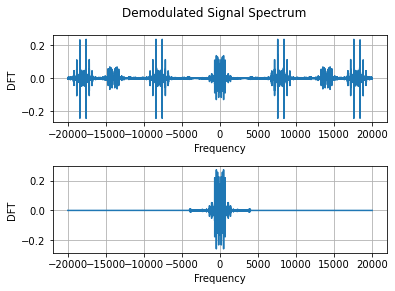

C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mosta\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


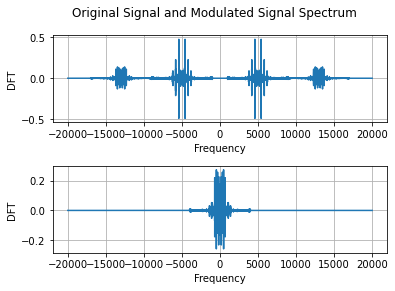

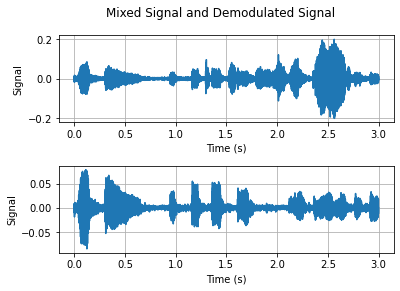

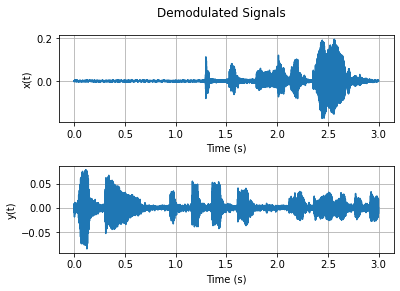

In [68]:
#Problem 2.5
fig, axs = plt.subplots(2)
axs[0].grid()
axs[1].grid()
fig.suptitle('Two Original Signals' )
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axs[0].plot(Treal, x1)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('x(t)')
axs[1].plot(Treal, x2)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('y(t)')
plt.show() 

x_recons1 = q_25(z, g1, fs, fmax)
x_recons2 = q_25(z, g2, fs, fmax)

fig, axs = plt.subplots(2)
axs[0].grid()
axs[1].grid()
fig.suptitle('Demodulated Signals' )
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axs[0].plot(Treal, x_recons1)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('x(t)')
axs[1].plot(Treal, x_recons2)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('y(t)')
plt.show()

We added the two voices in order to produce a z signal, and our goal now is to separate them. Since we truncated both our signals to remove any frequencies above 4000Hz, we know that if we modulate the signals so that they are centered at points over 4000Hz apart, we can prevent any superposition of the actual signals, and we will prevent any loss of information when we attempt to decouple them. Conveniently, we modulated our signals so that one was centered about 5000Hz and the other at 13000Hz. Since the signals were bandlimited so that any frequency over 4000Hz away from the center was set to 0, we know that all the first signal is contained between 1000Hz and 9000Hz in the frequency domain, and that the second is contained between 9000Hz and 17000Hz (we can ignore the negatives if we wish since the signals are both real, so the negative portions give the same information). We can then isolate frequencies between 1000Hz and 9000Hz and use them to reconstruct our first signal, and repeat the process for our second signal to obtain both our original signals.